# Quality of the data in general


Here I plot graphs of peak I and FWHM variations for different cycles.
All data were reduced using the SPHERE DC without normalisation (which is useful for this case and will be performed later)
Apperture polarimetry

Works for all ZIMPOL data reduced with individual cycles


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from matplotlib.ticker import ScalarFormatter,FormatStrFormatter,EngFormatter


In [2]:
def load_and_make_polar(dirdat,camera):
    dir = dirdat
    qfile = '*sci'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            q = hdulq[0].data[1]
            iu = hdulq[0].data[2]
            u = hdulq[0].data[3]
            n=q.shape[0]
             #Creating grid         
            xr = np.linspace(-n/2, n/2, num=n)
            yr = np.linspace(-n/2, n/2, num=n)
            x0 = 0.5
            y0 = 0.5
            xr = xr-x0
            yr = yr-y0
            Xr, Yr = np.meshgrid(xr, yr)
            R = np.sqrt(Xr**2 + Yr**2)
            phi = np.arctan(Yr/Xr)
            i=(iq+iu)/2
            q_phi=q*np.cos(2*phi)+u*np.sin(2*phi)
            q_phi = (q_phi > 0)*q_phi +  (q_phi <=0 )*1e-10
            u_phi=q*np.sin(2*phi)+u*np.cos(2*phi)
            pi=np.sqrt(q*q+u*u)
            aolp=0.5*np.arctan2(u, q)+np.pi/2
    return iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi


def load_and_make_polar_umon(dirdat,cycle,camera):
    #q
    dir = dirdat+'q_corr/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            q = hdulq[0].data
            n=q.shape[0]
    #u
    dir = dirdat+'u_corr/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            u = hdulq[0].data
    #qphi
    dir = dirdat+'qphi_corr/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            qphi = hdulq[0].data
            
    #uphi
    dir = dirdat+'uphi_corr/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            uphi = hdulq[0].data
            
            
            
    #iq,iu
    dir = dirdat+'sci/'
    qfile = '*_'+cycle+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            iu = hdulq[0].data[2]
            
            
            
             #Creating grid         
            xr = np.linspace(-n/2, n/2, num=n)
            yr = np.linspace(-n/2, n/2, num=n)
            x0 = 0.5
            y0 = 0.5
            xr = xr-x0
            yr = yr-y0
            Xr, Yr = np.meshgrid(xr, yr)
            R = np.sqrt(Xr**2 + Yr**2)
            phi = np.arctan(Yr/Xr)
            
            i=(iq+iu)/2
            
            qphi = (qphi > 0)*qphi +  (qphi <=0 )*1e-10
            pi=np.sqrt(q*q+u*u)
            aolp=0.5*np.arctan2(u, q)+np.pi/2
            
    return iq,q,iu,u,i,qphi,uphi,pi,aolp,R,phi


def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")   
        
        
def maskcrit(aolp,R):
    phi = (aolp-90)  
    n=aolp.shape[0]
    critarray=np.zeros_like(phi)
    for ix in range (0,n):
        for iy in range(0,n):
            if phi[ix,iy]>180:
                phi[ix,iy]=phi[ix,iy]-180
            
    for ix in range (2,n-2):
        for iy in range(2,n-2):
            if R[ix,iy]>=1:            
                datapix=[]
                for (iix,iiy) in [(ix,iy),(ix-1,iy),(ix+1,iy),(ix,iy-1),(ix,iy+1)]: 
                    if R[iix,iiy]>=1:
                        datapix.append(abs(phi[iix,iiy]))
                            
                
                crit=np.std(datapix)               
                critarray[ix,iy]=crit
                
    for ix in range (0,n-1):
        for iy in range(0,n-1):
            if critarray[ix,iy]==0:
                critarray[ix,iy]=np.max(critarray)
    medianstd=np.nanmedian(critarray)
    
    mask=(critarray<=medianstd)#*R([ix,iy]>=1)
    return mask
        
def plot_AoLP(ps,R,Q,U,I,Q_PHI,PI,AOLP,title,save):
    # First, we plot the background image
    fig = plt.figure(figsize=(8,8))
    i_plot = fig.add_subplot(111)
    n = I.shape[0]
    d = n * ps / 2

    im1=i_plot.imshow(np.arcsinh(Q_PHI), origin='lower',extent=(-d, d, d, -d))

    fig.colorbar(im1, orientation='vertical')

    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.tight_layout(pad=0.1)     

    # ranges of the axis
    xx0, xx1 = i_plot.get_xlim()
    yy0, yy1 = i_plot.get_ylim()

    # binning factor
    factor = [4, 4]

    # re-binned number of points in each axis
    nx_new = PI.shape[1] // factor[0]
    ny_new = PI.shape[0] // factor[1]

    # These are the positions of the quivers
    X,Y = np.meshgrid(np.linspace(xx0,xx1,nx_new,endpoint=True),
                      np.linspace(yy0,yy1,ny_new,endpoint=True))
    # bin the data
    I_bin = I.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_bin = Q.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    U_bin = U.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_phi_bin = Q_PHI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    PI_bin=PI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    R_bin=R.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    aolp_bin=AOLP.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)

    # polarization angle
    psi=0.5*np.arctan2(U_bin, Q_bin)

    #psi=aolp_bin
    #i_plot.imshow(psi, origin='lower',extent=(-d, d, d, -d))

    # polarization fraction
    frac =Q_phi_bin/I_bin
    #frac=dolp_v[adc:bdc,adc:bdc]
    # mask to show only alighned

    mask1=maskcrit(psi,R_bin)
    mask2=Q_phi_bin>=10
    mask=mask2#*mask1
    #print('max DoLP in region %.3f percent'%(np.max(frac[mask])*100))

    #+pi/2 because quiver function start counting from the horizontal axis counterclockwise 
    #and the AoLP have to start from North to East (which is also counterclockvise)
    pixX = frac*np.cos(psi+np.pi/2) # X-vector 
    pixY = frac*np.sin(psi+np.pi/2) # Y-vector

    # keyword arguments for quiverplots
    quiveropts = dict(headlength=0, headwidth=1, pivot='middle', color='w')
    i_plot.quiver(X[mask], Y[mask], pixX[mask], pixY[mask],scale=2, **quiveropts)
    plt.title(title)
    plt.savefig(save,bbox_inches='tight', pad_inches=0.1)
    #plt.show()#(dirName+"aolp.png",bbox_inches='tight', pad_inches=0.1)
    plt.close()
    
def gaus(x,a,x0,sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))

    
def find_FWHM (PSF,n,ps,figfolder,title):             #resolution
    middle=int(n/2)

    y1=PSF[middle,middle-60:middle+60]
    y2=PSF[middle-60:middle+60,middle]

    xdata = np.linspace(middle-60,middle+60, num=len(y1))


    n_gauss = len(xdata) #the number of data
    amp=np.max(y1)
    mean = np.sum(xdata * y1) / sum(y1)
    sigma = np.sqrt(sum(y1 * (xdata - mean)**2) / sum(y1))

    popt1,pcov1 = curve_fit(gaus,xdata,y1,p0=[amp,mean,sigma])
    popt2,pcov2 = curve_fit(gaus,xdata,y2,p0=[amp,mean,sigma])


    plt.plot(xdata, y1, 'o', label='vertical')
    plt.plot(xdata, gaus(xdata,*popt1), '-', label='fit1')
    plt.plot(xdata, y2, 'o', label='horizotal')
    plt.plot(xdata, gaus(xdata,*popt2), '-', label='fit2')
    plt.legend()
    plt.title(title)
    plt.savefig(figfolder+title+'.png',bbox_inches='tight', pad_inches=0.1)
    plt.close()

    fwhm1=2*np.sqrt(2*math.log(2))*popt1[2]
    fwhm2=2.355*popt2[2]


    fwhm=(abs(fwhm1)+abs(fwhm2))/2*ps

    return fwhm

def ap_fixed_in(rad,R,q,u,PSF):            
    mask = (R <= rad)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100
    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

def ap(radin,radout,R,q,u,PSF):
    mask = (R <= radout) * (R >= radin)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100

    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

In [3]:
#star='IRAS08544-4431'  'HD83878'   'HD75885' 'AR_Pup'
#stars=['HR4049_20190108','HR4049_20190107','HR4226','HD71253','HD94680','HD96314','HD98025','V709_Car','HD75885', 'AR_Pup_dc_notnorm','UMon']

# target (or few) you want to run the script for
stars=['HR4049_combined']
#list of star names with corresponding directories for different targets
starnames = {'HD75885':'HD75885','AR_Pup':'AR_Pup','HR4049_20190108':'HR4049-2019-01-08','HR4049_20190107':'HR4049-2019-01-07','HR4049_combined':'HR4049',
             'IRAS08544-4431':'IRAS08544-4431','UMon':'UMon','AR_Pup_dc_notnorm':'AR_Pup','V709_Car':'V709_Car','HD71253':'HD71253','HR4226':'HR4226',
            'HD83878':'HD83878','HD71253':'HD71253','HD94680':'HD94680','HD96314':'HD96314','HD98025':'HD98025','UMon_Katya':'UMon_Katya'}
fittypes=['1', '2'] #fittypes are the camera types in ZIMPOL (there are two cameras with different filters)

band=['V','I'] # corresponding filters of the data i was working on
ps=3.6 #mas/pixel for ZIMPOL



## Apperture polarimetry and other characteristics for each frame in the sample

### In the following cell: without correction of the intrinsic polarisation

max DoLP in the region R>=1.5 and R<500/ps  (500 mas in radius)


In [4]:

for star in stars:
    #figfolder=dirdat+'original/'
    figfolder='//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'
    createfolder(figfolder)
    figfolder=figfolder+ 'Quality_indiv_cycles/'
    createfolder(figfolder)
    figfolder0=figfolder+ star+'/'
    createfolder(figfolder0)
    figfolder=figfolder0+ 'no_unres_correction/'
    createfolder(figfolder)
    
    if star=='AR_Pup':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_indiv_process_list.csv'
    elif star=='AR_Pup_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Not_normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'


    elif star=='IRAS08544-4431':

        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08process_list.csv'
    elif star=='IRAS08544-4431_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08_not_norm_indiv_process_list.csv'
    
    elif star=='UMon':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/UMon_data/HansMartin/'
        input_filename =dirdat+'UMon_cycle_list.csv'
        
    else:
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/'+star+'/' 
        input_filename =dirdat+'process_list.csv'

  
        
    table = pd.read_csv(input_filename)
    table['reference']= table['reference'].str.replace(' ', '_') #ix in case there are spaces in the name

    processes=table['id']

    reference={process:ref for process,ref in zip(table['id'], table['reference'])}


    print(reference)

    for fittype in fittypes:
        #output_filename = dirdat+star+'_'+band[int(fittype)-1]+'_Original_AP_per_cycle.txt'
        output_filename = figfolder0+star+'_'+band[int(fittype)-1]+'_Original_AP_per_cycle.txt'
        with open(output_filename, 'w') as file_print:
            line="{:<30} {:<5} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}\n".format(
                'reference','cycle',"max_DoLP[%]", "max_Q_phi", "max_PI", "sumQ/I[%]", "sumQ_phi/I[%]","sumPI/I[%]",
                'FWHM','CNT60[%]','Peak_i(Strehl)','Peak_PI','peak_Q_Phi',
                '0-3_PSF', '0-3_Q', '0-3_U', '0-3_Q/I[%]', '0-3_U/I[%]',
                '0-5_PSF', '0-5_Q', '0-5_U', '0-5_Q/I[%]', '0-5_U/I[%]',
                '0-10_PSF', '0-10_Q', '0-10_U', '0-10_Q/I[%]', '0-10_U/I[%]',
                '0-50_PSF', '0-50_Q', '0-50_U', '0-50_Q/I[%]', '0-50_U/I[%]',
                '0-100_PSF', '0-100_Q', '0-100_U', '0-100_Q/I[%]', '0-100_U/I[%]',
                '1-3_PSF', '1-3_Q', '1-3_U', '1-3_Q/I[%]', '1-3_U/I[%]',
                '3-5_PSF', '3-5_Q', '3-5_U', '3-5_Q/I[%]', '3-5_U/I[%]',
                '3-30_PSF', '3-30_Q', '3-30_U', '3-30_Q/I[%]', '3-30_U/I[%]',
                '5-30_PSF', '5-30_Q', '5-30_U', '5-30_Q/I[%]', '5-30_U/I[%]')

            file_print.write(line)
          
            for process in processes:
                
                print(process)
                
                if star=='UMon':
                    dirName=dirdat
                    iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar_umon(dirName,process,fittype)
                else:        
                    dirName=dirdat+'SPHERE_DC_DATA/'+str(process)+'/'
                    iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar(dirName,fittype)

                n=q.shape[0]
                if star=='AR_Pup':
                    lim=150       
                else:
                    lim=50       

                filename={0:'PI',1:'Q_phi', 2:"U_phi",3:'Q',4:'U',5:'I'}
                
                frac =np.max(np.divide(q_phi,i,where=i!=0)*(R<=500/ps)*(R>=1.5))*100
                mask=(R<=500/ps)
                q_sum=np.sum(q[mask])
                qphi_sum=np.sum(q_phi[mask])
                I_sum=np.sum(i[mask])
                pi_sum=np.sum(pi[mask])

                fwhm=find_FWHM (i,n,ps,figfolder,band[int(fittype)-1]+'_gauss_'+reference[process])
                #normalise the image to the 10e6, might be useful for further comparison ZIMPOL with IRDIS but not really now.
                mask=(R<=1500/ps)
                middle=int(n/2)
                ctn6=i*np.sum(i[mask])/10e6
                cnt60=np.max(ctn6[middle-1:middle+1,middle-1:middle+1])/10e6*100

                #calculating what is the ratio of peak brightness to the total. For I it refers to the observational conditions and is a proxy of strehl
                normalisation=np.sum(i[mask])
                peak_i=np.max(i*(R<200))/normalisation
                peak_pi=np.max(pi*(R<200))/normalisation
                peak_q_phi=np.max(q_phi*(R<200))/normalisation #migh be less informative than PI because of unresolved signal in the center
                
                
                 #extracting cyclenumber from reference
                if star=='HD83878'  or star=='UMon_Katya' or star== 'HD75885' or star== 'HD71253' or star=='HD94680' or star=='HD96314' or star=='HD98025' or star=='HR4226':
                    cycle_number=reference[process].split('_')[1][:-1]
                elif star=='UMon':
                    cycle_number=reference[process][3:]
                else:
                    cycle_number=reference[process].split('_')[2][:-1]
                   
                psf_sum3, q_sum3, u_sum3, q_i_percent3, u_i_percent3=ap_fixed_in(3,R,q,u,i)     
                psf_sum5, q_sum5, u_sum5, q_i_percent5, u_i_percent5=ap_fixed_in(5,R,q,u,i)
                psf_sum10, q_sum10, u_sum10, q_i_percent10, u_i_percent10=ap_fixed_in(10,R,q,u,i)            
                psf_sum50, q_sum50, u_sum50, q_i_percent50, u_i_percent50=ap_fixed_in(50,R,q,u,i)            
                psf_sum100, q_sum100, u_sum100, q_i_percent100, u_i_percent100=ap_fixed_in(100,R,q,u,i)            

                psf_sum1_3, q_sum1_3, u_sum1_3, q_i_percent1_3, u_i_percent1_3=ap(1,3,R,q,u,i)
                psf_sum3_5, q_sum3_5, u_sum3_5, q_i_percent3_5, u_i_percent3_5=ap(3,5,R,q,u,i)
                psf_sum5_30, q_sum5_30, u_sum5_30, q_i_percent5_30, u_i_percent5_30=ap(5,30,R,q,u,i)
                psf_sum3_30, q_sum3_30, u_sum3_30, q_i_percent3_30, u_i_percent3_30=ap(3,30,R,q,u,i)




                line = "{:<30} {:<5} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.6f} {:<15.8f} {:<15.8f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} \n".format(  \
                        reference[process],cycle_number, \
                        frac, np.max(q_phi), np.max(pi), q_sum/I_sum*100, qphi_sum/I_sum*100, pi_sum/I_sum*100, \
                        fwhm,cnt60,peak_i,peak_pi,peak_q_phi, \
                        psf_sum3, q_sum3, u_sum3, q_i_percent3, u_i_percent3, \
                        psf_sum5, q_sum5, u_sum5, q_i_percent5, u_i_percent5, \
                        psf_sum10, q_sum10, u_sum10, q_i_percent10, u_i_percent10, \
                        psf_sum50, q_sum50, u_sum50, q_i_percent50, u_i_percent50, \
                        psf_sum100, q_sum100, u_sum100, q_i_percent100, u_i_percent100, \
                        psf_sum1_3, q_sum1_3, u_sum1_3, q_i_percent1_3, u_i_percent1_3, \
                        psf_sum3_5, q_sum3_5, u_sum3_5, q_i_percent3_5, u_i_percent3_5, \
                        psf_sum3_30, q_sum3_30, u_sum3_30, q_i_percent3_30, u_i_percent3_30,  \
                        psf_sum5_30, q_sum5_30, u_sum5_30, q_i_percent5_30, u_i_percent5_30)
                file_print.write(line)
                #print(line)

                for fileindex,image1 in enumerate([pi,q_phi, u_phi,q,u,i]):
                    image_an = image1*(R<250)
                    image=np.arcsinh(image_an)
                    fig, ax = plt.subplots()
                    f.plottingroutinemas(image,lim,ps,n,star,ax)        
                    f.scale_mas(star,ax)  

                    plt.title(reference[process]+', '+filename[fileindex]+', '+band[int(fittype)-1]) 
                    plt.savefig(figfolder+band[int(fittype)-1]+'_'+filename[fileindex]+'_'+reference[process]+'.png',bbox_inches='tight', pad_inches=0.1)
                    #plt.show()
                    plt.close()









{573544: 'HR4049_20190107_20c_07_41-43_not_norm', 573543: 'HR4049_20190107_19c_07_39-41(1)_not_norm', 573542: 'HR4049_20190107_18c_07_38-39(2)_not_norm', 573541: 'HR4049_20190107_17c_07_36-37_not_norm', 573540: 'HR4049_20190107_16c_07_34-35_not_norm', 573539: 'HR4049_20190107_15c_07_32-33_not_norm', 573538: 'HR4049_20190107_14c_07_30-31_not_norm', 573537: 'HR4049_20190107_13c_07_28-30(1)_not_norm', 573536: 'HR4049_20190107_12c_07_26-28(1)_not_norm', 573535: 'HR4049_20190107_11c_07_24-26(1)_not_norm', 573534: 'HR4049_20190107_10c_07_23-24(1)_not_norm', 573533: 'HR4049_20190107_9c_07_21-22_not_norm', 573532: 'HR4049_20190107_8c_07_19-20_not_norm', 573531: 'HR4049_20190107_7c_07_17-18_not_norm', 573530: 'HR4049_20190107_6c_07_15-16_not_norm', 573529: 'HR4049_20190107_5c_07_13-15(1)_not_norm', 573528: 'HR4049_20190107_4c_07_11-13(1)_not_norm', 573527: 'HR4049_20190107_3c_07_09-11(1)_not_norm', 573526: 'HR4049_20190107_2c_07_08-09(1)_not_norm', 573525: 'HR4049_20190107_1c_07_06-07_not_nor

### In the following cell all the same but with correction of the intrinsic polarisation


In [5]:
# appertures for the calculation of unresolved polarisation signal
annuli=[3,5]#,10,200,270]
annuli_name={3:'0-3',5:'0-5',10:'0-10',200:'30-200',270:'100-200'}


   
for star in stars:
    figfolder0='//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'
    createfolder(figfolder0)
    figfolder0=figfolder0+ 'Quality_indiv_cycles/'
    createfolder(figfolder0)
    figfolder0=figfolder0+ star+'/'
    createfolder(figfolder0)

    if star=='AR_Pup':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_indiv_process_list.csv'
    elif star=='AR_Pup_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Not_normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'


    elif star=='IRAS08544-4431':

        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08process_list.csv'
    elif star=='IRAS08544-4431_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08_not_norm_indiv_process_list.csv'
    
    elif star=='UMon':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/UMon_data/HansMartin/'
        input_filename =dirdat+'UMon_cycle_list.csv'
        
    else:
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/'+star+'/' 
        input_filename =dirdat+'process_list.csv'
        
    table = pd.read_csv(input_filename)
    table['reference']= table['reference'].str.replace(' ', '_') #ix in case there are spaces in the name

    processes=table['id']

    reference={process:ref for process,ref in zip(table['id'], table['reference'])}
    


    print(reference)
    for annulus in annuli:
        print(annuli_name[annulus])
        figfolder=figfolder0+ annuli_name[annulus]+'_unres_correction/'
        createfolder(figfolder)
        #figfolder=dirdat+'images_'+annuli_name[annulus]+'/'
        for fittype in fittypes: 
            output_filename = figfolder0+star+'_'+annuli_name[annulus]+'_'+band[int(fittype)-1]+'_AP_per_cycle.txt'
            
            with open(output_filename, 'w') as file_print:
                line="{:<30} {:<5} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}\n".format(
                        'reference','cycle',"max_DoLP[%]", "max_Q_phi", "max_PI", "sumQ/I[%]", "sumQ_phi/I[%]","sumPI/I[%]",
                        'FWHM','CNT60[%]','Peak_i(Strehl)','Peak_PI','peak_Q_Phi',
                        '0-3_PSF', '0-3_Q', '0-3_U', '0-3_Q/I[%]', '0-3_U/I[%]',
                        '0-5_PSF', '0-5_Q', '0-5_U', '0-5_Q/I[%]', '0-5_U/I[%]',
                        '0-10_PSF', '0-10_Q', '0-10_U', '0-10_Q/I[%]', '0-10_U/I[%]',
                        '0-50_PSF', '0-50_Q', '0-50_U', '0-50_Q/I[%]', '0-50_U/I[%]',
                        '0-100_PSF', '0-100_Q', '0-100_U', '0-100_Q/I[%]', '0-100_U/I[%]',
                        '1-3_PSF', '1-3_Q', '1-3_U', '1-3_Q/I[%]', '1-3_U/I[%]',
                        '3-5_PSF', '3-5_Q', '3-5_U', '3-5_Q/I[%]', '3-5_U/I[%]',
                        '3-30_PSF', '3-30_Q', '3-30_U', '3-30_Q/I[%]', '3-30_U/I[%]',
                        '5-30_PSF', '5-30_Q', '5-30_U', '5-30_Q/I[%]', '5-30_U/I[%]')

                file_print.write(line)
                for process in processes:
                    
                    print(reference[process])    
                    
                    if star=='UMon':
                        dirName=dirdat
                        iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar_umon(dirName,process,fittype)
                    else:        
                        dirName=dirdat+'SPHERE_DC_DATA/'+str(process)+'/'
                        iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar(dirName,fittype)

                    n=q.shape[0]
                     #Creating grid         
                    if star=='AR_Pup':
                        lim=150       
                    else:
                        lim=50       
                    #Correction for the unresolved polarisation
                    correction_radius=annulus
                    if annulus==200:
                        mask=(R<=correction_radius)*(R>=30)
                    if annulus==270:
                        mask=(R<=200)*(R>=100)
                    else:
                        mask=(R<=correction_radius)

                    q_over_i=np.divide(q,i,where=i!=0)   

                    
                    cq=np.median(q_over_i[mask]) #for median normal as in IRDIS
                    u_over_i=np.divide(u,i,where=i!=0)    
                    cu=np.median(u_over_i[mask]) #for median normal as in IRDIS
                    q_corr=q-cq*iq
                    u_corr=u-cu*iu
                    q_phi_corr=q_corr*np.cos(2*phi)+u_corr*np.sin(2*phi)
                    q_phi_corr = (q_phi_corr> 0)*q_phi_corr +  (q_phi_corr <=0 )*1e-10
                    u_phi_corr=q_corr*np.sin(2*phi)+u_corr*np.cos(2*phi)
                    pi_corr=np.sqrt(q_corr*q_corr+u_corr*u_corr)
                    aolp_corr=0.5*np.arctan2(u_corr, q_corr)+np.pi/2
                    angleofpol=np.rad2deg(0.5*np.arctan2(cu, cq))
                    if angleofpol<0: angleofpol+=180

                    frac =np.max(np.divide(q_phi_corr,i,where=i!=0)*(R<=500/ps)*(R>1.5))*100
                    mask=(R<=500/ps)
                    q_sum=np.sum(q_corr[mask])
                    qphi_sum=np.sum(q_phi_corr[mask])
                    I_sum=np.sum(i[mask])
                    pi_sum=np.sum(pi_corr[mask])

                    fwhm=find_FWHM (i,n,ps,figfolder,band[int(fittype)-1]+'_gauss_'+reference[process])
                    #normalise the image to the 10e6, might be useful for further comparison ZIMPOL with IRDIS but not really now.
                    mask=(R<=1500/ps)

                    middle=int(n/2)
                    ctn6=i*np.sum(i[mask])/10e6
                    cnt60=np.max(ctn6[middle-1:middle+1,middle-1:middle+1])/10e6*100

                    #calculating what is the ratio of peak brightness to the total in 3'' apperture. For I it refers to the observational conditions and is a proxy of strehl
                    normalisation=np.sum(i[mask])
                    peak_i=np.max(i*(R<500/ps))/normalisation
                    peak_pi=np.max(pi_corr*(R<500/ps))/normalisation
                    peak_q_phi=np.max(q_phi_corr*(R<500/ps))/normalisation #migh be less informative than PI because of unresolved signal in the center

                    #extracting cyclenumber from reference 
                    if star=='HD83878' or star=='UMon_Katya' or star== 'HD75885' or star== 'HD71253' or star=='HD94680' or star=='HD96314' or star=='HD98025' or star=='HR4226':
                        cycle_number=reference[process].split('_')[1][:-1] 
                    elif star=='UMon':
                        cycle_number=reference[process][3:]
                    else:
                        cycle_number=reference[process].split('_')[2][:-1]
                    psf_sum3, q_sum3, u_sum3, q_i_percent3, u_i_percent3=ap_fixed_in(3,R,q_corr,u_corr,i)     
                    psf_sum5, q_sum5, u_sum5, q_i_percent5, u_i_percent5=ap_fixed_in(5,R,q_corr,u_corr,i)
                    psf_sum10, q_sum10, u_sum10, q_i_percent10, u_i_percent10=ap_fixed_in(10,R,q_corr,u_corr,i)            
                    psf_sum50, q_sum50, u_sum50, q_i_percent50, u_i_percent50=ap_fixed_in(50,R,q_corr,u_corr,i)            
                    psf_sum100, q_sum100, u_sum100, q_i_percent100, u_i_percent100=ap_fixed_in(100,R,q_corr,u_corr,i)            

                    psf_sum1_3, q_sum1_3, u_sum1_3, q_i_percent1_3, u_i_percent1_3=ap(1,3,R,q_corr,u_corr,i)
                    psf_sum3_5, q_sum3_5, u_sum3_5, q_i_percent3_5, u_i_percent3_5=ap(3,5,R,q_corr,u_corr,i)
                    psf_sum5_30, q_sum5_30, u_sum5_30, q_i_percent5_30, u_i_percent5_30=ap(5,30,R,q_corr,u_corr,i)
                    psf_sum3_30, q_sum3_30, u_sum3_30, q_i_percent3_30, u_i_percent3_30=ap(3,30,R,q_corr,u_corr,i)



                    line = "{:<30} {:<5} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.6f} {:<15.8f} {:<15.8f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} \n".format(  \
                        reference[process],cycle_number, \
                        frac, np.max(q_phi_corr), np.max(pi_corr), q_sum/I_sum*100, qphi_sum/I_sum*100, pi_sum/I_sum*100, \
                        fwhm,cnt60,peak_i,peak_pi,peak_q_phi, \
                        psf_sum3, q_sum3, u_sum3, q_i_percent3, u_i_percent3, \
                        psf_sum5, q_sum5, u_sum5, q_i_percent5, u_i_percent5, \
                        psf_sum10, q_sum10, u_sum10, q_i_percent10, u_i_percent10, \
                        psf_sum50, q_sum50, u_sum50, q_i_percent50, u_i_percent50, \
                        psf_sum100, q_sum100, u_sum100, q_i_percent100, u_i_percent100, \
                        psf_sum1_3, q_sum1_3, u_sum1_3, q_i_percent1_3, u_i_percent1_3, \
                        psf_sum3_5, q_sum3_5, u_sum3_5, q_i_percent3_5, u_i_percent3_5, \
                        psf_sum3_30, q_sum3_30, u_sum3_30, q_i_percent3_30, u_i_percent3_30,  \
                        psf_sum5_30, q_sum5_30, u_sum5_30, q_i_percent5_30, u_i_percent5_30)


                    file_print.write(line)
                    #print(line)

                    #plotting part
                    filename={0:'Q_phi_corr',1:'U_phi_corr',2:'PI_corr'}

                    for fileindex,image1 in enumerate([q_phi_corr,u_phi_corr,pi_corr]):
                        image_an = image1*(R<250)
                        image=np.arcsinh(image_an)
                        fig, ax = plt.subplots()
                        f.plottingroutinemas(image,lim,ps,n,star,ax)        
                        f.scale_mas(star,ax)  

                        plt.title(reference[process]+', '+filename[fileindex]+', '+annuli_name[annulus]+', '+band[int(fittype)-1]) 
                        plt.savefig(figfolder+band[int(fittype)-1]+'_'+filename[fileindex]+'_'+reference[process]+'.png',bbox_inches='tight', pad_inches=0.1)
                        #plt.show()
                        plt.close()
                    adc=int(440)
                    bdc=int(n-440)

                    title=reference[process]+', '+'AoLP'+', '+annuli_name[annulus]+', '+band[int(fittype)-1]

                    save=figfolder+band[int(fittype)-1]+'_aolp_'+reference[process]+'.png'
                    plot_AoLP(ps,R[adc:bdc,adc:bdc],q_corr[adc:bdc,adc:bdc],u_corr[adc:bdc,adc:bdc],i[adc:bdc,adc:bdc],q_phi_corr[adc:bdc,adc:bdc],pi_corr[adc:bdc,adc:bdc],aolp_corr[adc:bdc,adc:bdc],title,save)




{573544: 'HR4049_20190107_20c_07_41-43_not_norm', 573543: 'HR4049_20190107_19c_07_39-41(1)_not_norm', 573542: 'HR4049_20190107_18c_07_38-39(2)_not_norm', 573541: 'HR4049_20190107_17c_07_36-37_not_norm', 573540: 'HR4049_20190107_16c_07_34-35_not_norm', 573539: 'HR4049_20190107_15c_07_32-33_not_norm', 573538: 'HR4049_20190107_14c_07_30-31_not_norm', 573537: 'HR4049_20190107_13c_07_28-30(1)_not_norm', 573536: 'HR4049_20190107_12c_07_26-28(1)_not_norm', 573535: 'HR4049_20190107_11c_07_24-26(1)_not_norm', 573534: 'HR4049_20190107_10c_07_23-24(1)_not_norm', 573533: 'HR4049_20190107_9c_07_21-22_not_norm', 573532: 'HR4049_20190107_8c_07_19-20_not_norm', 573531: 'HR4049_20190107_7c_07_17-18_not_norm', 573530: 'HR4049_20190107_6c_07_15-16_not_norm', 573529: 'HR4049_20190107_5c_07_13-15(1)_not_norm', 573528: 'HR4049_20190107_4c_07_11-13(1)_not_norm', 573527: 'HR4049_20190107_3c_07_09-11(1)_not_norm', 573526: 'HR4049_20190107_2c_07_08-09(1)_not_norm', 573525: 'HR4049_20190107_1c_07_06-07_not_no

### Creating images

Directory  //media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Quality_indiv_cycles/HR4049_combined/  already exists
                                  reference  cycle  max_DoLP[%]  max_Q_phi  \
0     HR4049_20190107_20c_07_41-43_not_norm     20        3.316    264.412   
1  HR4049_20190107_19c_07_39-41(1)_not_norm     19        3.370    271.650   
2  HR4049_20190107_18c_07_38-39(2)_not_norm     18        3.918    338.182   
3     HR4049_20190107_17c_07_36-37_not_norm     17        3.667    299.257   
4     HR4049_20190107_16c_07_34-35_not_norm     16        2.871    163.577   

    max_PI  sumQ/I[%]  sumQ_phi/I[%]  sumPI/I[%]    FWHM  CNT60[%]  ...  \
0  338.555     -0.009          0.535       0.776  28.530     0.655  ...   
1  332.413      0.035          0.572       0.803  27.629     0.768  ...   
2  395.287      0.031          0.605       0.840  27.628     0.788  ...   
3  669.080      0.137          0.584       0.823  27.597     0.715  ...   
4  197.752      0.085          0

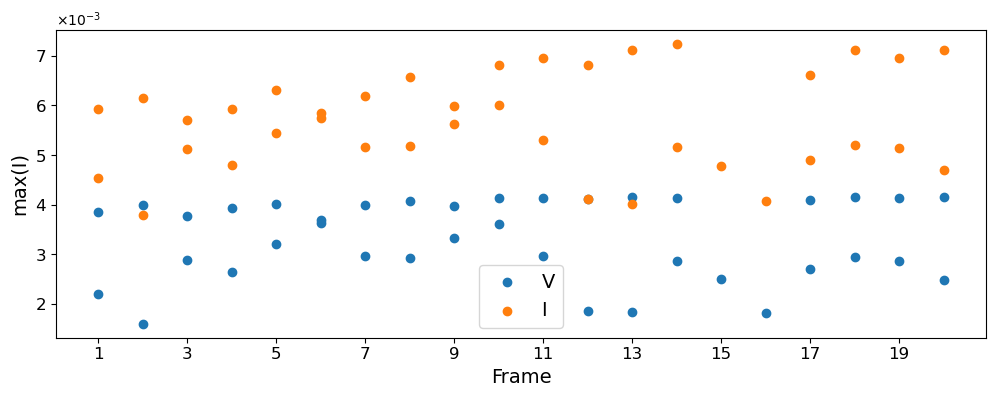

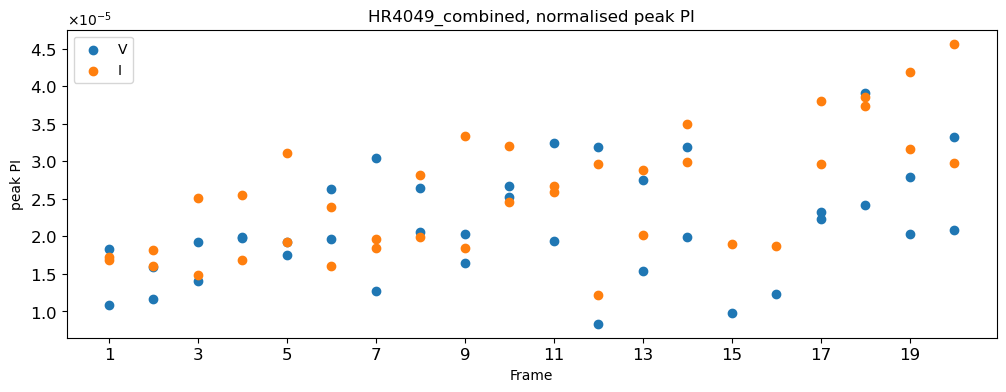

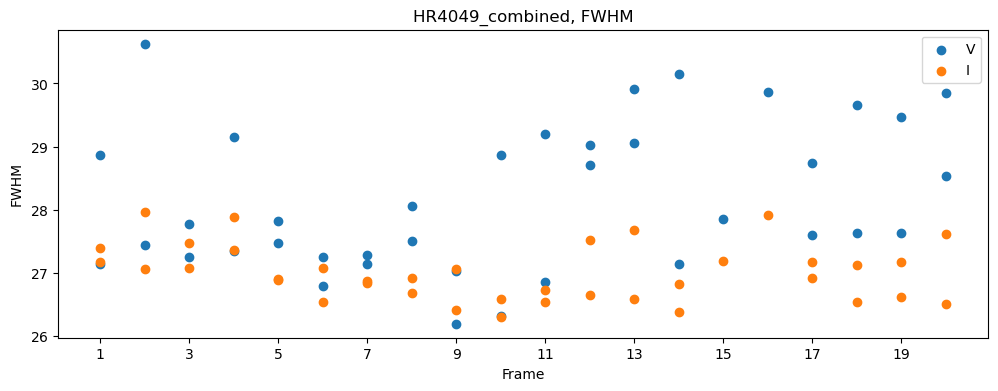

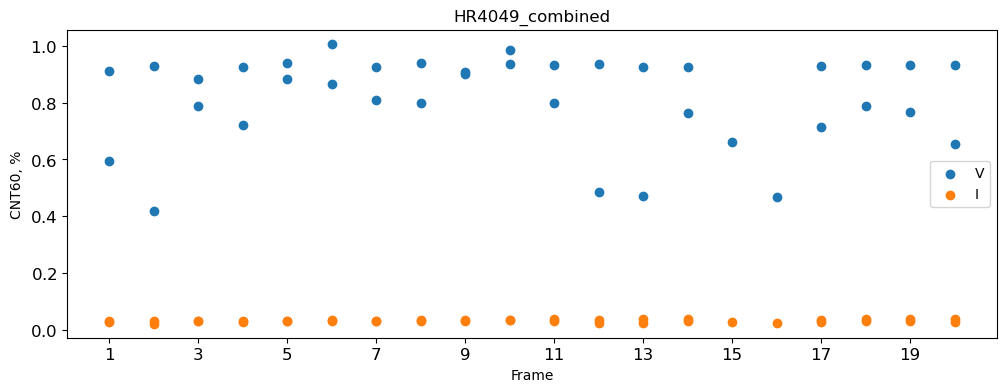

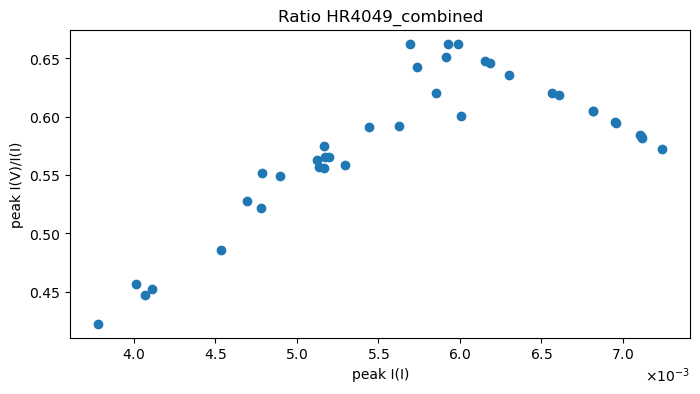

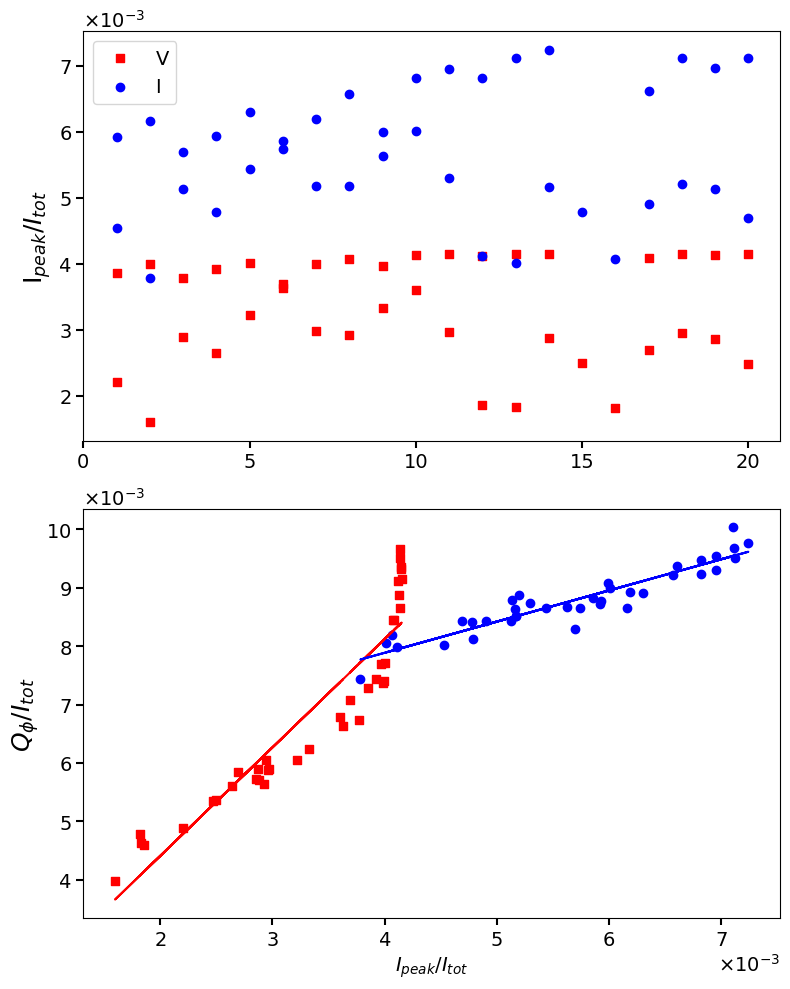

In [6]:
for star in stars:
    if star=='AR_Pup':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_indiv_process_list.csv'
    elif star=='AR_Pup_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Not_normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'


    elif star=='IRAS08544-4431':

        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08process_list.csv'
    elif star=='IRAS08544-4431_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08_not_norm_indiv_process_list.csv'
    
    elif star=='UMon':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/UMon_data/HansMartin/'
        input_filename =dirdat+'UMon_cycle_list.csv'
        
    else:
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/'+star+'/' 
        input_filename =dirdat+'process_list.csv'
  
    #folders where figures are saved
    figfolder0='//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Quality_indiv_cycles/'+ star+'/'
    specific_folder='//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Quality_indiv_cycles/'+star+'/'   #dirdat+'quality/'
    
    try:
    # Create target Directory
       os.mkdir(specific_folder)
    except FileExistsError:
        print("Directory " , specific_folder,  " already exists")
        
    output_filename = figfolder0+star+'_V_Original_AP_per_cycle.txt'
    df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+star+'_I_Original_AP_per_cycle.txt'
    df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)
  
    output_filename = figfolder0+star+'_0-3_V_AP_per_cycle.txt'
    df_0_3_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+star+'_0-3_I_AP_per_cycle.txt'
    df_0_3_i = pd.read_csv(output_filename, delim_whitespace=True)
 
    print(df_orig_v.head())
    
    plt.figure(figsize=(12, 4))
    plt.scatter(df_orig_v['cycle'],df_orig_v['Peak_i(Strehl)'],label='V')
    plt.scatter(df_orig_i['cycle'],df_orig_i['Peak_i(Strehl)'],label='I')
    plt.ylabel('max(I)', fontsize=14)
    plt.xlabel("Frame", fontsize=14)  
    #plt.title(star+', normalised peak I')
    plt.xticks(ticks=range(np.min(df_orig_v['cycle']),np.max(df_orig_v['cycle']),2),fontsize=12)
    plt.yticks(fontsize=12)
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.legend(fontsize=14)
    plt.savefig(specific_folder +star+'_peakI.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
   
    plt.figure(figsize=(12, 4))
    plt.scatter(df_orig_v['cycle'],df_orig_v['Peak_PI'],label='V')
    plt.scatter(df_orig_i['cycle'],df_orig_i['Peak_PI'],label='I')
    plt.ylabel('peak PI')
    plt.xlabel("Frame")  
    plt.xticks(ticks=range(np.min(df_orig_v['cycle']),np.max(df_orig_v['cycle']),2),fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(star+', normalised peak PI')
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    
    plt.legend()
    plt.savefig(specific_folder +star+'_peakPI.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
    plt.figure(figsize=(12, 4))
    plt.scatter(df_orig_v['cycle'],df_orig_v['FWHM'],label='V')
    plt.scatter(df_orig_i['cycle'],df_orig_i['FWHM'],label='I')
    plt.xticks(ticks=range(np.min(df_orig_v['cycle']),np.max(df_orig_v['cycle']),2))
    plt.ylabel('FWHM')
    plt.xlabel("Frame")  
    plt.title(star+', FWHM')
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    
    plt.legend()
    plt.savefig(specific_folder +star+'_fwhm.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
    plt.figure(figsize=(12, 4))
    plt.scatter(df_orig_v['cycle'],df_orig_v['CNT60[%]'],label='V')
    plt.scatter(df_orig_i['cycle'],df_orig_i['CNT60[%]'],label='I')
    plt.ylabel('CNT60, %')
    plt.xlabel("Frame")  
    plt.yticks(fontsize=12)
    plt.xticks(ticks=range(np.min(df_orig_v['cycle']),np.max(df_orig_v['cycle']),2), fontsize=12)
    plt.title(star)
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    
    plt.legend()
    plt.savefig(specific_folder +star+'_cnt60.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

    
    plt.figure(figsize=(8, 4))
    ratio={}
    ratio = df_orig_v['Peak_i(Strehl)']/df_orig_i['Peak_i(Strehl)']
    plt.scatter(df_orig_i['Peak_i(Strehl)'],ratio)
    plt.ylabel('peak I(V)/I(I)')
    plt.xlabel("peak I(I)")
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))  
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.title('Ratio '+star)
    plt.savefig(specific_folder +star+'_peakRatio.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
   
   
    
    #for paper
    plt.figure(figsize=(8, 10))
    
    # Subplot 1: Peak I
    plt.subplot(2, 1, 1)
    plt.scatter(df_orig_v['cycle'], df_orig_v['Peak_i(Strehl)'],marker='s', label='V',color='red')
    plt.scatter(df_orig_i['cycle'], df_orig_i['Peak_i(Strehl)'], label='I',color='blue')
    plt.ylabel('I$_{peak}/I_{tot}$', fontsize=18)
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().yaxis.offsetText.set_fontsize(14)
    plt.xticks(ticks=range(np.min(df_orig_v['cycle'])-1, np.max(df_orig_v['cycle'])+1, 5), fontsize=14)
    plt.tick_params(axis='both', labelbottom=True,length=5,width=1.5,labelsize=14)  # Remove labeled ticks on the x-axis
    plt.legend(fontsize=14)

    # Subplot 2: Qphi
    plt.subplot(2, 1, 2)
    plt.scatter(df_orig_v['Peak_i(Strehl)'], df_orig_v['sumQ_phi/I[%]']/100,marker='s',color='red')
    slope, intercept = np.polyfit(df_orig_v['Peak_i(Strehl)'], df_orig_v['sumQ_phi/I[%]']/100, deg=1)
    plt.plot(df_orig_v['Peak_i(Strehl)'],slope*df_orig_v['Peak_i(Strehl)']+intercept,color='red')
    plt.scatter(df_orig_i['Peak_i(Strehl)'], df_orig_i['sumQ_phi/I[%]']/100,color='blue')
    slope, intercept = np.polyfit(df_orig_i['Peak_i(Strehl)'], df_orig_i['sumQ_phi/I[%]']/100, deg=1)
    plt.plot(df_orig_i['Peak_i(Strehl)'],slope*df_orig_i['Peak_i(Strehl)']+intercept,color='blue')
    plt.ylabel('$Q_{\phi}/I_{tot}$', fontsize=18)
    plt.xlabel("$I_{peak}/I_{tot}$", fontsize=14)  
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().yaxis.offsetText.set_fontsize(14)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().xaxis.offsetText.set_fontsize(14)
    #plt.xticks(ticks=range(np.min(df_orig_v['cycle'])-1, np.max(df_orig_v['cycle'])+1, 5), fontsize=14)
    plt.tick_params(axis='both',length=5,width=1.5,labelsize=14) 
   
    # Adjust x-axis limits to include the last tick
    #plt.xlim(np.min(df_orig_v['cycle'])-1, np.max(df_orig_v['cycle'])+1)
    plt.tight_layout()
    plt.savefig(specific_folder + star + '_for_paper.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

## Variation of apperture polarimetry among frames (polarisation cycles)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['reference' 'cycle' 'max_DoLP[%]' 'max_Q_phi' 'max_PI' 'sumQ/I[%]'
 'sumQ_phi/I[%]' 'sumPI/I[%]' 'FWHM' 'CNT60[%]' 'Peak_i(Strehl)' 'Peak_PI'
 'peak_Q_Phi' '0-3_PSF' '0-3_Q' '0-3_U' '0-3_Q/I[%]' '0-3_U/I[%]'
 '0-5_PSF' '0-5_Q' '0-5_U' '0-5_Q/I[%]' '0-5_U/I[%]' '0-10_PSF' '0-10_Q'
 '0-10_U' '0-10_Q/I[%]' '0-10_U/I[%]' '0-50_PSF' '0-50_Q' '0-50_U'
 '0-50_Q/I[%]' '0-50_U/I[%]' '0-100_PSF' '0-100_Q' '0-100_U'
 '0-100_Q/I[%]' '0-100_U/I[%]' '1-3_PSF' '1-3_Q' '1-3_U' '1-3_Q/I[%]'
 '1-3_U/I[%]' '3-5_PSF' '3-5_Q' '3-5_U' '3-5_Q/I[%]' '3-5_U/I[%]'
 '3-30_PSF' '3-30_Q' '3-30_U' '3-30_Q/I[%]' '3-30_U/I[%]' '5-30_PSF'
 '5-30_Q' '5-30_U' '5-30_Q/I[%]' '5-30_U/I[%]']


<Figure size 1200x400 with 0 Axes>

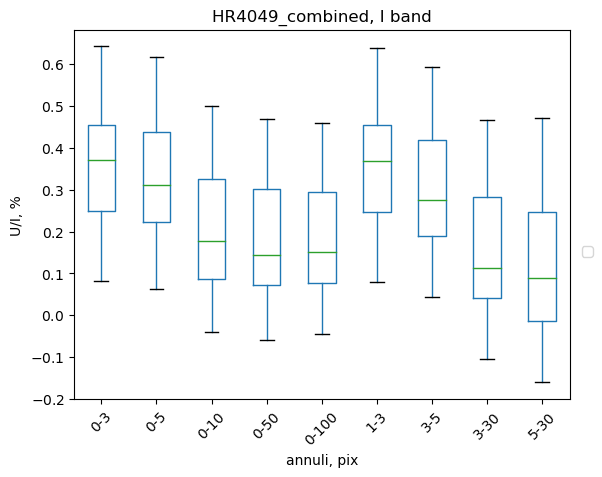

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1200x400 with 0 Axes>

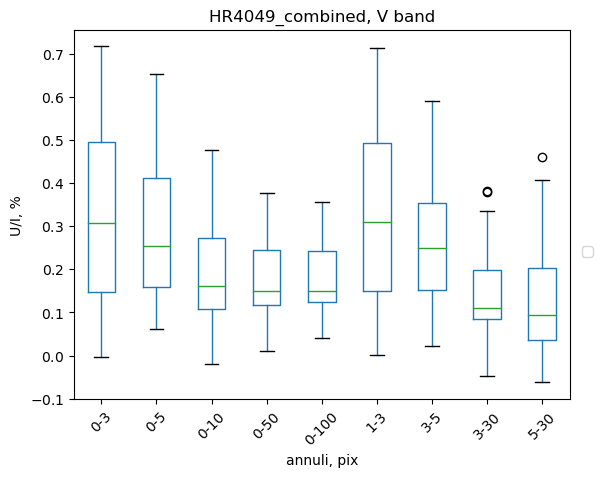

<Figure size 1200x400 with 0 Axes>

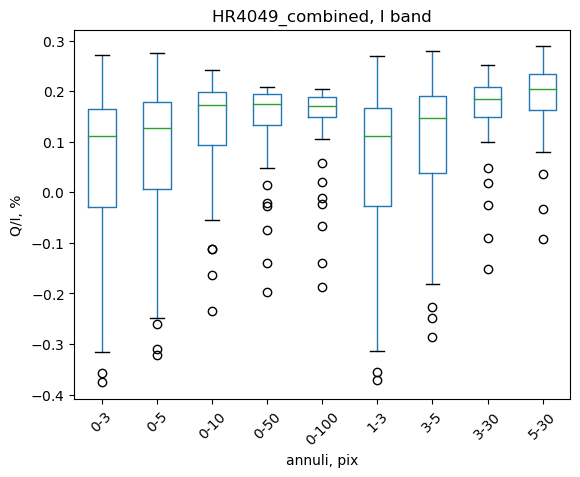

<Figure size 1200x400 with 0 Axes>

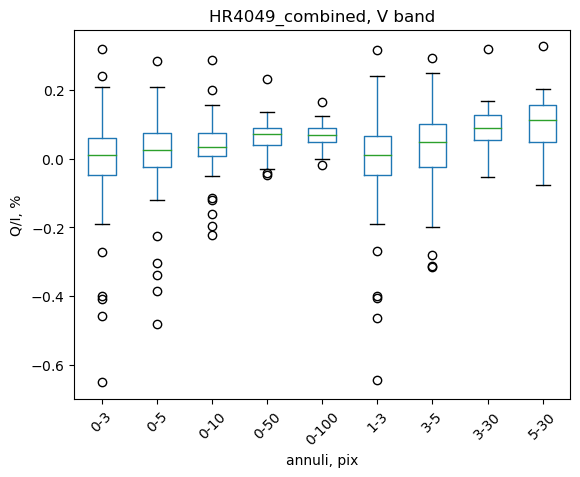

In [7]:
#plotting aperture photometry

for star in stars:
    if star=='AR_Pup':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_indiv_process_list.csv'
    elif star=='AR_Pup_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Not_normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'


    elif star=='IRAS08544-4431':

        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08process_list.csv'
    elif star=='IRAS08544-4431_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08_not_norm_indiv_process_list.csv'
    
    elif star=='UMon':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/UMon_data/HansMartin/'
        input_filename =dirdat+'UMon_cycle_list.csv'
        
    else:
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/'+star+'/' 
        input_filename =dirdat+'process_list.csv'
        
    figfolder0='//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Quality_indiv_cycles/'+ star+'/'
    
    specific_folder='//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Quality_indiv_cycles/'+star+'/variation_in_frames/'   #dirdat+'quality/'
    #specific_folder=dirdat+'quality/'
    try:
    # Create target Directory
       os.mkdir(specific_folder)
    except FileExistsError:
        print("Directory " , specific_folder,  " already exists")
        
    output_filename = figfolder0+star+'_V_Original_AP_per_cycle.txt'
    df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+star+'_I_Original_AP_per_cycle.txt'
    df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)
  
    output_filename = figfolder0+star+'_0-3_V_AP_per_cycle.txt'
    df_0_3_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+star+'_0-3_I_AP_per_cycle.txt'
    df_0_3_i = pd.read_csv(output_filename, delim_whitespace=True)
 
    print(df_orig_v.columns.values)

    
    
    
    cycle_numbers = df_orig_v['cycle']
    current_labels = ['0-3', '0-5', '0-10', '0-50', '0-100', '1-3', '3-5', '3-30', '5-30']
    current_columnU = ['0-3_U/I[%]', '0-5_U/I[%]', '0-10_U/I[%]', '0-50_U/I[%]', '0-100_U/I[%]', '1-3_U/I[%]', '3-5_U/I[%]', '3-30_U/I[%]', '5-30_U/I[%]']
    current_columnQ = ['0-3_Q/I[%]', '0-5_Q/I[%]', '0-10_Q/I[%]', '0-50_Q/I[%]', '0-100_Q/I[%]', '1-3_Q/I[%]', '3-5_Q/I[%]', '3-30_Q/I[%]', '5-30_Q/I[%]']
    
    plt.figure(figsize=(12, 4))
    df_orig_i[current_columnU].plot(kind='box')
    positions = range(1, len(current_columnU) + 1)
    plt.xticks(positions, current_labels)
    plt.ylabel('U/I, %') 
    plt.xlabel('annuli, pix')
    plt.title(star + ', I band')
    formatter = plt.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    ax = plt.subplot(111)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.4))
   
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.savefig(specific_folder + star + '_I_UI_annuli.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
    
   
    
    plt.figure(figsize=(12, 4))
    # Plot each current data with the corresponding label and cycle numbers in the legend
    df_orig_v[current_columnU].plot(kind='box')
    plt.xticks(positions, current_labels)
    plt.ylabel('U/I, %')
    plt.xlabel('annuli, pix')
    plt.title(star + ', V band')
    formatter = plt.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    ax = plt.subplot(111)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.4))
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.savefig(specific_folder + star + '_V_UI_annuli.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
    
    
    plt.figure(figsize=(12, 4))
    # Plot each current data with the corresponding label and cycle numbers in the legend
    df_orig_i[current_columnQ].plot(kind='box')
    plt.xticks(positions, current_labels)
    plt.ylabel('Q/I, %')
    plt.xlabel('annuli, pix')
    plt.title(star + ', I band')
    formatter = plt.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.savefig(specific_folder + star + '_I_QI_annuli.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
    plt.figure(figsize=(12, 4))
    # Plot each current data with the corresponding label and cycle numbers in the legend
    df_orig_v[current_columnQ].plot(kind='box')
    plt.xticks(positions, current_labels)
    plt.xlabel('annuli, pix')
    plt.ylabel('Q/I, %')
    plt.title(star + ', V band')
    formatter = plt.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.savefig(specific_folder + star + '_V_QI_annuli.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
      

## Quality values for the data

In [8]:

for star in stars:
    

    figfolder0='//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Quality_indiv_cycles/'+ star+'/'
    
    specific_folder='//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Quality_indiv_cycles/'+star+'/'
    # Create target Directory
    try:
        os.mkdir(specific_folder)
    except FileExistsError:
        print("Directory " , specific_folder,  " already exists")
        
    output_filename = figfolder0+star+'_V_Original_AP_per_cycle.txt'
    df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+star+'_I_Original_AP_per_cycle.txt'
    df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)
  
    #output_filename = dirdat+star+'_0-3_V_AP_per_cycle.txt'
    #df_0_3_v = pd.read_csv(output_filename, delim_whitespace=True)
    #output_filename = dirdat+star+'_0-3_I_AP_per_cycle.txt'
    #df_0_3_i = pd.read_csv(output_filename, delim_whitespace=True)
 
    #print(df_orig_v.head())
    print(star)
    print('V')
    print('median peak I normalised to total %.6f percents +- %.6f'%(np.median(df_orig_v['Peak_i(Strehl)']*100),np.std(df_orig_v['Peak_i(Strehl)']*100)))
    print('median CNT60 normalised to total %.6f percents +- %.6f'%(np.median(df_orig_v['CNT60[%]']),np.std(df_orig_v['CNT60[%]'])))
    
    print('median peak PI normalised to total I %.6f percents +- %.6f'%(np.median(df_orig_v['Peak_PI']*100),np.std(df_orig_v['Peak_PI']*100)))
    
    print('median FWHM %.3f mas +- %.3f'%(np.median(df_orig_v['FWHM']),np.std(df_orig_v['FWHM'])))
    print('ratio of FWHM %.3f  '%(np.max(df_orig_v['FWHM'])/np.min(df_orig_v['FWHM'])))
    
    print('I')
    print('median peak I normalised to total %.6f percents +- %.6f'%(np.median(df_orig_i['Peak_i(Strehl)']*100),np.std(df_orig_i['Peak_i(Strehl)']*100)))
    print('median CNT60 normalised to total %.6f percents +- %.6f'%(np.median(df_orig_i['CNT60[%]']),np.std(df_orig_i['CNT60[%]'])))
    
    print('median peak PI normalised to total I %.6f percents +- %.6f'%(np.median(df_orig_i['Peak_PI']*100),np.std(df_orig_i['Peak_PI']*100)))
    
    print('median FWHM %.3f mas +- %.3f'%(np.median(df_orig_i['FWHM']),np.std(df_orig_i['FWHM'])))
    print('ratio of FWHM %.3f  '%(np.max(df_orig_i['FWHM'])/np.min(df_orig_i['FWHM'])))
    
    

Directory  //media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Quality_indiv_cycles/HR4049_combined/  already exists
HR4049_combined
V
median peak I normalised to total 0.361750 percents +- 0.078964
median CNT60 normalised to total 0.893000 percents +- 0.156008
median peak PI normalised to total I 0.002009 percents +- 0.000711
median FWHM 27.797 mas +- 1.138
ratio of FWHM 1.169  
I
median peak I normalised to total 0.571900 percents +- 0.096005
median CNT60 normalised to total 0.030000 percents +- 0.004211
median peak PI normalised to total I 0.002531 percents +- 0.000821
median FWHM 26.921 mas +- 0.439
ratio of FWHM 1.063  


In [9]:
#stars=['IRAS08544-4431', 'IRAS08544-4431_dc_notnorm','AR_Pup','AR_Pup_dc_notnorm']
#stars=['HR4049_20190108','HR4049_20190107','HD71253','HD94680','HD96314','HD98025','V709_Car','HR4226','UMon_Katya']
stars=['HR4049_combined']

for star in stars:
    

    figfolder0='//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Quality_indiv_cycles/'+ star+'/'
    
    specific_folder='//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Quality_indiv_cycles/'+star+'/'
    # Create target Directory
    try:
        os.mkdir(specific_folder)
    except FileExistsError:
        print("Directory " , specific_folder,  " already exists")
        
    output_filename = figfolder0+star+'_V_Original_AP_per_cycle.txt'
    df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+star+'_I_Original_AP_per_cycle.txt'
    df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)
  
    #print(df_orig_v.columns)
    print(df_orig_v.FWHM)
    

Directory  //media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Quality_indiv_cycles/HR4049_combined/  already exists
0     28.530
1     27.629
2     27.628
3     27.597
4     29.868
5     27.857
6     27.138
7     29.062
8     28.714
9     26.854
10    26.319
11    26.195
12    27.512
13    27.284
14    26.786
15    27.470
16    29.152
17    27.778
18    30.630
19    28.865
20    29.846
21    29.477
22    29.658
23    28.747
24    30.146
25    29.908
26    29.019
27    29.193
28    28.864
29    27.028
30    28.052
31    27.145
32    27.245
33    27.815
34    27.340
35    27.254
36    27.447
37    27.140
Name: FWHM, dtype: float64


## Number of counts per frame

In [10]:

for star in stars:
    #figfolder=dirdat+'original/'
    
    
    if star=='AR_Pup':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_indiv_process_list.csv'
    elif star=='AR_Pup_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/AR_Pup/Not_normalised/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'


    elif star=='IRAS08544-4431':

        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08process_list.csv'
    elif star=='IRAS08544-4431_dc_notnorm':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/'  #For IRAS08
        input_filename =dirdat+'IRAS08_not_norm_indiv_process_list.csv'
    
    elif star=='UMon':
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/UMon_data/HansMartin/'
        input_filename =dirdat+'UMon_cycle_list.csv'
        
    else:
        dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/'+star+'/' 
        input_filename =dirdat+'process_list.csv'
  
        
    table = pd.read_csv(input_filename)
    table['reference']= table['reference'].str.replace(' ', '_') #ix in case there are spaces in the name

    processes=table['id']

    reference={process:ref for process,ref in zip(table['id'], table['reference'])}


    #print(reference)
    print(star)
    for fittype in fittypes:
        #output_filename = dirdat+star+'_'+band[int(fittype)-1]+'_Original_AP_per_cycle.txt'
        print(band[int(fittype)-1])
        for process in processes:
            if star=='UMon':
                dirName=dirdat
                iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar_umon(dirName,process,fittype)
            else:        
                dirName=dirdat+'SPHERE_DC_DATA/'+str(process)+'/'
                iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar(dirName,fittype)

            n=q.shape[0]

            iq_sum=np.sum(iq)
            iu_sum=np.sum(iu)
            pi_sum=np.sum(pi)
            print('sum of IQ %.2e, IU %.2e, PI %.2e' % (iq_sum, iu_sum, pi_sum))



HR4049_combined
V
sum of IQ 1.73e+07, IU 1.72e+07, PI 3.92e+05
sum of IQ 1.74e+07, IU 1.73e+07, PI 3.90e+05
sum of IQ 1.74e+07, IU 1.74e+07, PI 4.02e+05
sum of IQ 1.74e+07, IU 1.74e+07, PI 4.09e+05
sum of IQ 1.72e+07, IU 1.73e+07, PI 3.72e+05
sum of IQ 1.75e+07, IU 1.74e+07, PI 3.67e+05
sum of IQ 1.75e+07, IU 1.75e+07, PI 3.75e+05
sum of IQ 1.73e+07, IU 1.74e+07, PI 3.68e+05
sum of IQ 1.75e+07, IU 1.74e+07, PI 3.70e+05
sum of IQ 1.76e+07, IU 1.76e+07, PI 3.68e+05
sum of IQ 1.77e+07, IU 1.77e+07, PI 3.85e+05
sum of IQ 1.76e+07, IU 1.76e+07, PI 4.08e+05
sum of IQ 1.76e+07, IU 1.77e+07, PI 3.54e+05
sum of IQ 1.77e+07, IU 1.75e+07, PI 3.60e+05
sum of IQ 1.77e+07, IU 1.77e+07, PI 3.89e+05
sum of IQ 1.76e+07, IU 1.77e+07, PI 3.82e+05
sum of IQ 1.76e+07, IU 1.76e+07, PI 3.61e+05
sum of IQ 1.75e+07, IU 1.76e+07, PI 3.73e+05
sum of IQ 1.73e+07, IU 1.74e+07, PI 3.45e+05
sum of IQ 1.75e+07, IU 1.75e+07, PI 3.79e+05
sum of IQ 1.56e+07, IU 1.55e+07, PI 4.62e+05
sum of IQ 1.57e+07, IU 1.56e+07, PI 4